<a href="https://colab.research.google.com/github/tyinglin/ml_for_iot_/blob/main/project_1_tyinglin_awahler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 1: Keyword Spotting**
## by Thomas Yingling and Amanda Wahler

## **Basic Steps**

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.
7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. Rebuild Arduino program, run it, recognize the two target words.
9. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

Library Requirements:

*   conda install -c anaconda seaborn
*   Google 30 dataset
*   !apt-get install xxd
*   !xxd -i kws_model.tflite > trained_model_data.cc



In [305]:
import sys
import os
import pathlib
import glob
import PIL

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

try:
  from google.colab import drive
  drive.mount('/content/drive')
except: pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [306]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
use_microfrontend = True
dataset = 'mini-speech' # 'full-speech'

## Get Google Dataset from URL
List Commands in Dataset we can use for part 1 of project

In [307]:
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/ecgr_4090_m_w_iot/project 1/audio_snips/keywords_generated/')
# if dataset == 'mini-speech':
#   data_dir = pathlib.Path('data/mini_speech_commands')  
#   if not data_dir.exists():
#     tf.keras.utils.get_file('mini_speech_commands.zip',
#           origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#           extract=True, cache_dir='.', cache_subdir='data')
#   commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#   commands = commands[commands != 'README.md']
# elif dataset == 'full-speech':
#   data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
#   commands = ['cat', 'dog']

commands = ['banana', 'go']
print('Commands:', commands)

Commands: ['banana', 'go']


Pull out audio files from google, shuffle the audio files

In [308]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 6000
Number of examples per label: 1500
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/ecgr_4090_m_w_iot/project 1/audio_snips/keywords_generated/banana/banana.0073.wav', shape=(), dtype=string)


Split into training, testing, and validation sets

In [309]:
# With 8000 sets, 1000 labels.
# Created 80% Training, 10% testing, and 10% validation
# 6400:800:800 Respectively

# if dataset == 'mini-speech':
#   num_train_files = 6400 
#   num_val_files = 800
#   num_test_files = num_samples - num_train_files - num_val_files
#   train_files = filenames[:num_train_files]
#   val_files = filenames[num_train_files: num_train_files + num_val_files]
#   test_files = filenames[-num_test_files:]
# elif dataset == 'full-speech':
#   raise ValueError("full-speech has not been completed yet. Use mini-speech or fix the code")
# else:
#   raise ValueError("dataset must be either full-speech or mini-speech")

num_train_files = 6000
num_val_files = 800
num_test_files = num_samples - num_train_files - num_val_files
train_files = filenames[:num_train_files]
val_files = filenames[num_train_files: num_train_files + num_val_files]
test_files = filenames[-num_test_files:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6000
Validation set size 0
Test set size 5200


### **Reading Audio Files**

Sample rate at 16 kHz

Decode Wave Files with tf.audio.decode_wav

In [310]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

Get Label From Wave

In [311]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

Main Function that breaks down WAV files and extracts audio-label pairs. Used for Supervised Training.

In [312]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

## Decomposing the Waveforms for the Neural Network
### Functions for spectrogram and pre processing data sets

Another Main Function: Gets spectrogram from wave files. 
These can then be pushed through the Neural Network

In [313]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=40,
                                    window_size=40, window_step=20)
  return spectrogram

Plot Spectrogram function that shapes the wave and adds color mesh

In [314]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

Work waves into tensors

In [315]:
def wavds2specds(waveform_ds):
  spec_grams = np.zeros((0, 49, 40, 1))
  labels = []
  for wav, label in waveform_ds:
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams = np.concatenate((spec_grams, spectrogram))
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == commands)
    labels.append(new_label_id) # for numeric labels
    # labels.append(new_label) # for string labels
  return tf.data.Dataset.from_tensor_slices((spec_grams, labels)) 

Pre process the data for the tensors from the waves

In [316]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  output_ds = wavds2specds(waveform_ds)
  return output_ds

## Plot exisiting Waves and their Spectrograms for each command and sample conversion

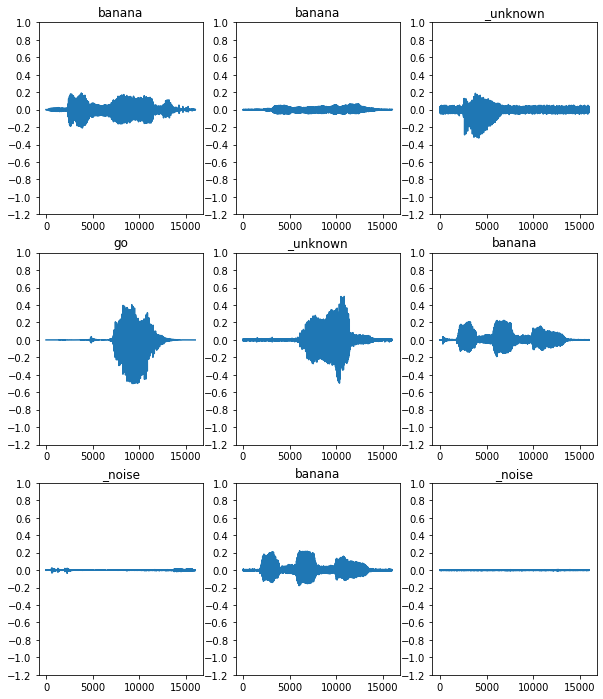

In [317]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Get Spectrogram version of wave file, provide info on file

In [318]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: banana
Waveform shape: (16000,)
Spectrogram shape: (49, 40)
Audio playback


Plot this spectrogram version of the waveform

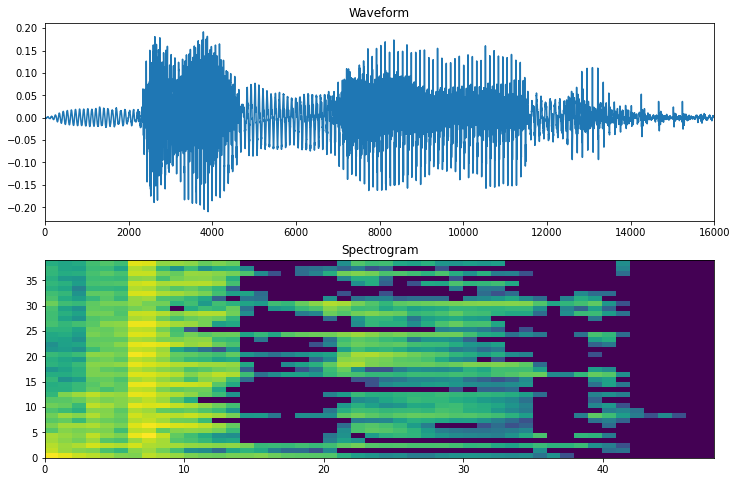

In [319]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Provide Spectrogram to all commands available

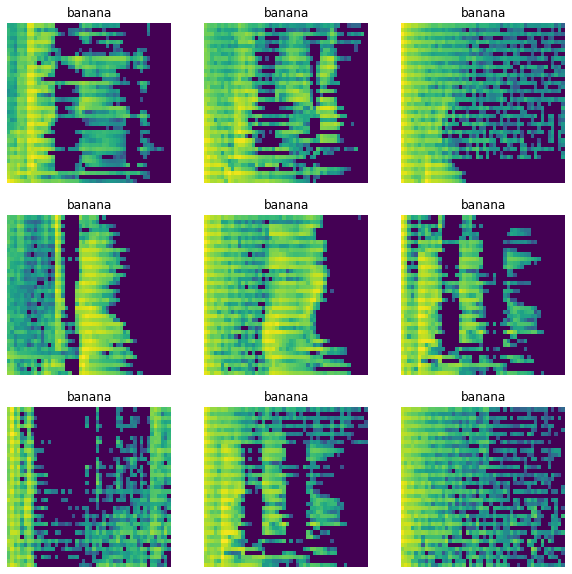

In [320]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Processing Waveforms through a Neural Network

In [321]:
## training set is already builst
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [322]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [323]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (49, 40, 1)
ranges from 0.0 to 707.0


In [324]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [325]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (49, 40, 1)


## Neural Network Model

In [326]:
print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Normalization(),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.BatchNormalization(),

    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Input shape: (49, 40, 1)
Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 49, 40, 1)         3         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 47, 38, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 23, 19, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 8, 64)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 8, 64)         256       
_________________________________________________________________
dropout_14 (Dropout)         (N

In [327]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [328]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
94/94 [==============================] - 13s 128ms/step - loss: 0.1557 - accuracy: 0.9560


Epoch 2/10
94/94 [==============================] - 12s 126ms/step - loss: 2.0060e-05 - accuracy: 1.0000


Epoch 3/10
94/94 [==============================] - 12s 126ms/step - loss: 1.8056e-05 - accuracy: 1.0000


Epoch 4/10
94/94 [==============================] - 12s 126ms/step - loss: 1.7955e-06 - accuracy: 1.0000


Epoch 5/10
94/94 [==============================] - 12s 125ms/step - loss: 8.8909e-05 - accuracy: 1.0000


Epoch 6/10
94/94 [==============================] - 12s 126ms/step - loss: 9.2155e-07 - accuracy: 1.0000


Epoch 7/10
94/94 [==============================] - 12s 125ms/step - loss: 2.1201e-05 - accuracy: 1.0000


Epoch 8/10
94/94 [==============================] - 12s 126ms/step - loss: 6.7807e-07 - accuracy: 1.0000


Epoch 9/10
94/94 [==============================] - 12s 126ms/step - loss: 3.7161e-06 - accuracy: 1.0000


Epoch 10/10
94/94 [==============================] - 12s 126ms/step - loss: 9.4068e-07 - accuracy: 1.0000


## Data of Model: Confusion Matrix, Sample Wave, Loss in Neural Network

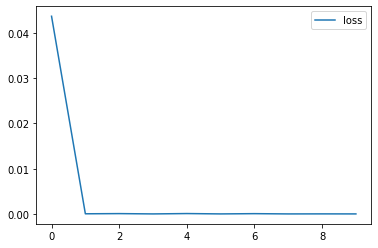

In [329]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.show()

In [330]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [331]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


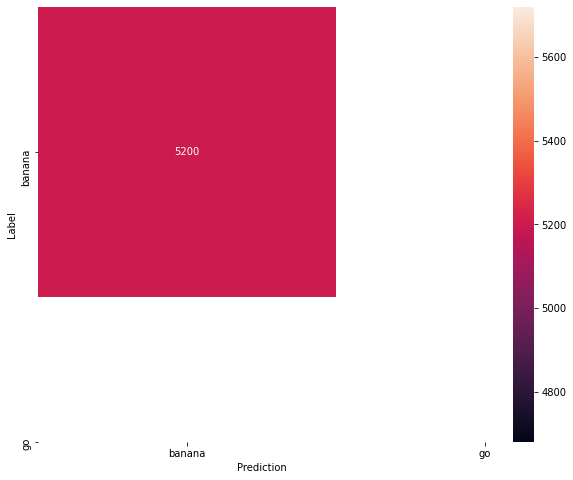

In [332]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Pull a sample file from data directory, predict it in neural network to test training

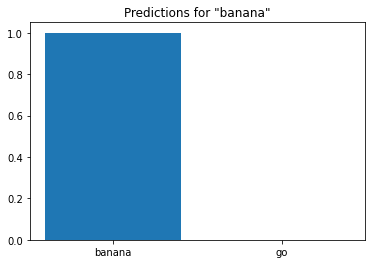

In [333]:
sample_file = data_dir/'banana/banana.1497.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

## Creating a tflite model, transforming it to hex, prepare files for microcontroller

In [334]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [335]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [336]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [337]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp02j8h4q9/assets


INFO:tensorflow:Assets written to: /tmp/tmp02j8h4q9/assets


RuntimeError: ignored

In [ ]:
fname = 'kws_model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

In [ ]:
!apt-get install xxd
!xxd -i kws_model.tflite > trained_model_data.cc